In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('DBLP-V1')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema, prefix_id=True)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

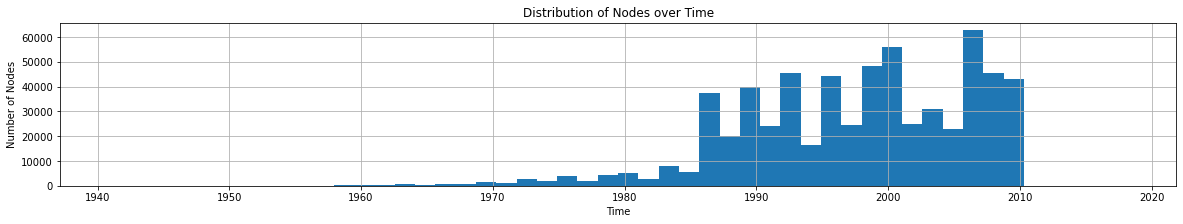

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 1238188
Number of Edges: 2501669
Density: 1.6317627555873819e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 4.040854862104947
Median Degree: 2.0


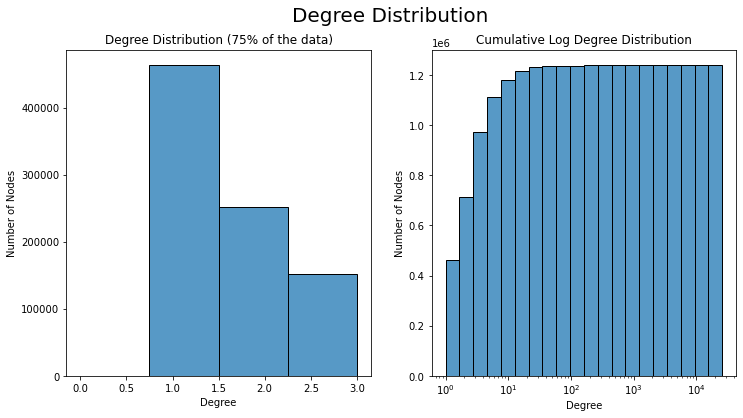

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,25929,
1,7107,Communications of the ACM
2,5057,Computer
3,3715,Jr.
4,3451,IEEE Transactions on Computers
5,3388,Discrete Mathematics
6,3271,Theoretical Computer Science
7,3091,Journal of Computational and Applied Mathematics
8,2903,Microelectronic Engineering
9,2897,Journal of Computational Physics


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.019
Diameter: 35


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    u = 0
    # metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,page_rank,transitivity
count,1.157439e+06,1.157439e+06,1.157439e+06,764630.000000
mean,3.659800e-06,4.917183e-06,8.639764e-07,0.030868
std,2.625456e-05,6.014099e-04,1.037383e-05,0.105881
min,8.639772e-07,0.000000e+00,1.296248e-07,0.000000
25%,8.639772e-07,0.000000e+00,2.764725e-07,0.000000
50%,1.727954e-06,0.000000e+00,4.967864e-07,0.000000
75%,3.455909e-06,8.639787e-07,9.560036e-07,0.000000
max,2.240206e-02,4.213350e-01,1.032736e-02,1.000000


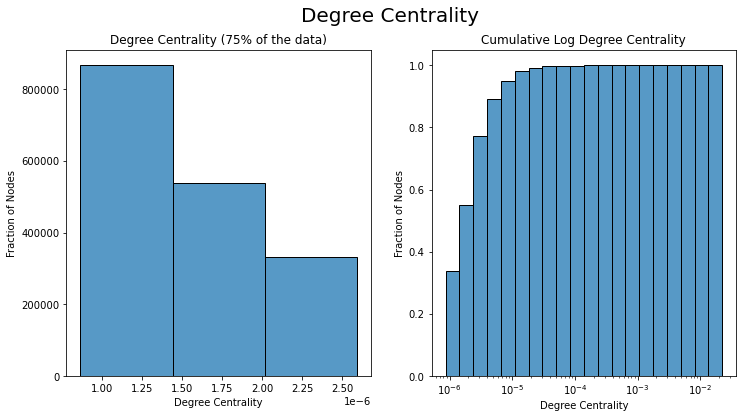

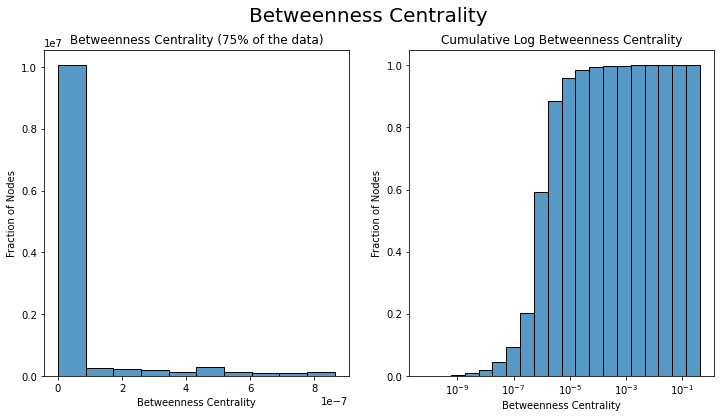

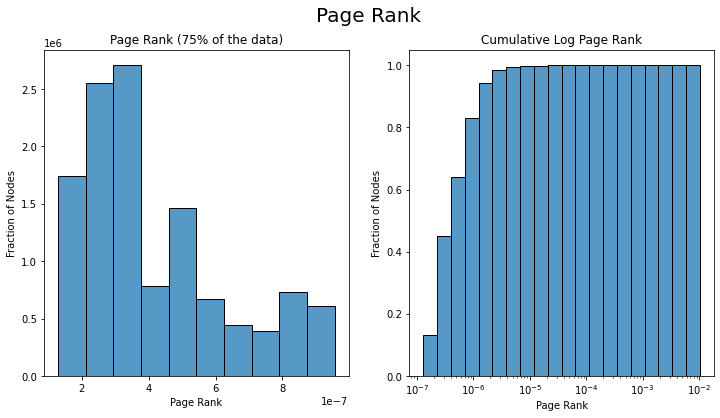

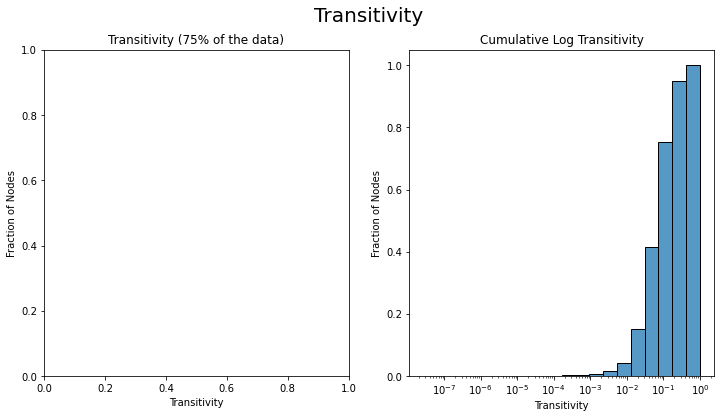

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,0.421335,Robust computational secret sharing and a unif...,0.010327,,1.0,Robert J. Sheraga
1,0.006140,Communications of the ACM,0.282057,How convincing is your protocol?,0.001390,Computer,1.0,On modularity and compilation in a government-...
2,0.004369,Computer,0.201790,,0.001386,Communications of the ACM,1.0,William F. Rich
3,0.003210,Jr.,0.161455,ACM SIGACT News,0.000894,Discrete Mathematics,1.0,Stephen W. Strom
4,0.002982,IEEE Transactions on Computers,0.139757,Communications of the ACM,0.000718,Journal of Computational and Applied Mathematics,1.0,Ian Westmacott
5,0.002927,Discrete Mathematics,0.131491,How to share a secret,0.000673,Jr.,1.0,Karl Denninghoff
6,0.002826,Theoretical Computer Science,0.085246,Statistically-hiding commitment from any one-w...,0.000664,BYTE,1.0,J. Claussen
7,0.002671,Journal of Computational and Applied Mathematics,0.082280,Paillier's cryptosystem revisited,0.000660,Theoretical Computer Science,1.0,Juha Helminen
8,0.002508,Microelectronic Engineering,0.072436,Security without identification: transaction s...,0.000637,Fuzzy Sets and Systems,1.0,Paul B. Beskow
9,0.002503,Journal of Computational Physics,0.063963,Journal of Cryptology,0.000597,Information Processing Letters,1.0,Rohit Wagle


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 32767
Size of the largest component: 1157439


Text(0.5, 1.0, 'Connected Components')

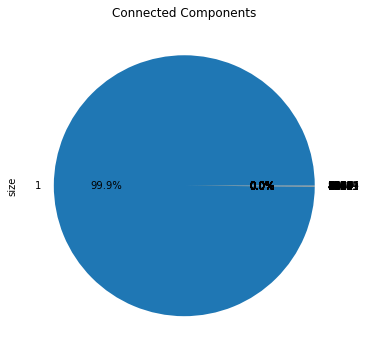

In [21]:
df_tmp = pd.Series(list(map(len, G.components("weak"))), name='size', index=range(1,len(G.components("weak"))+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,595775,2.245311,1.0
Paper,Paper,629804,4.976818,3.0
Venue,Venue,12609,42.130066,14.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

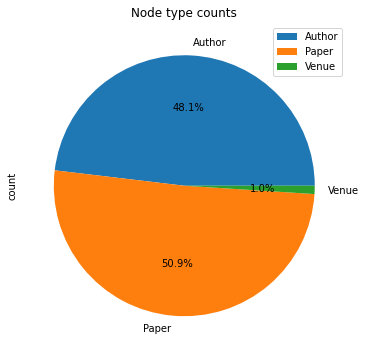

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

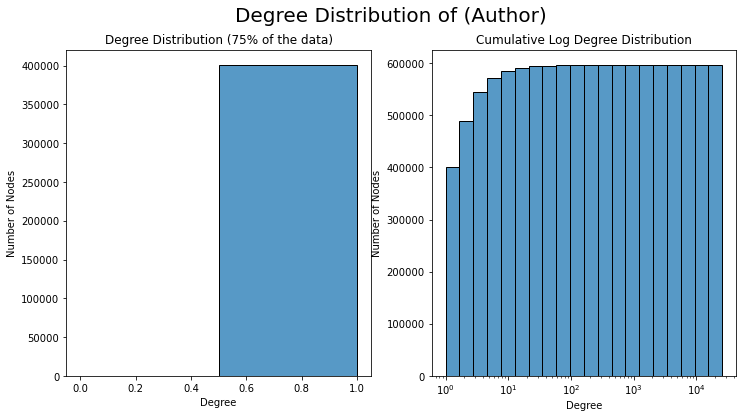

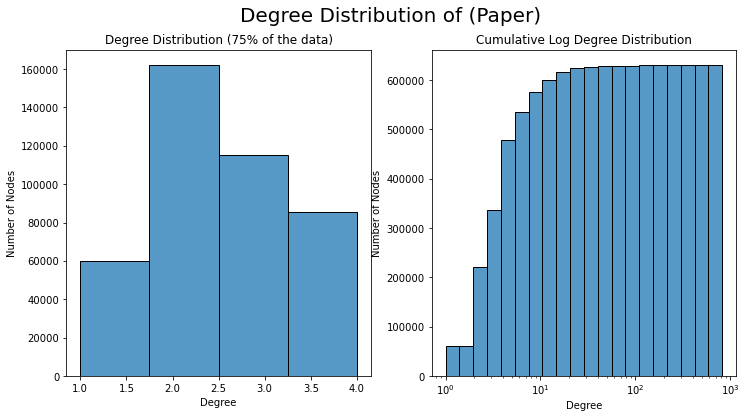

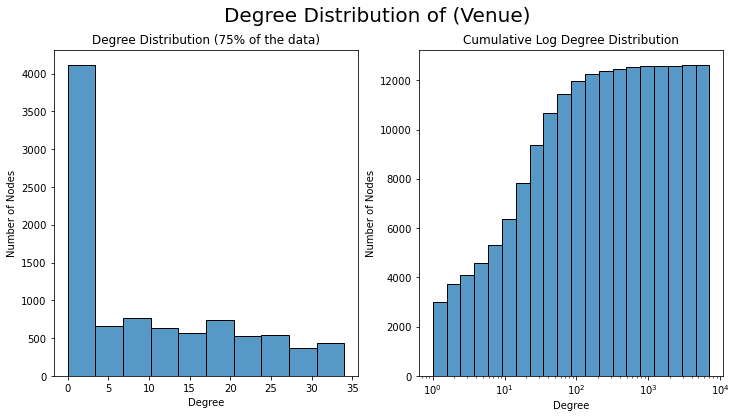

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,25929,
1,3715,Jr.
2,695,III
3,392,II
4,390,Staff
5,209,Ben Shneiderman
6,206,Philip S. Yu
7,176,Elisa Bertino
8,171,Thomas J. Cashman
9,170,Wei Wang


Top 10 Degree Nodes of Type (Paper)


,value,label
0,819,Introduction to algorithms
1,794,"Compilers: principles, techniques, and tools"
2,649,C4.5: programs for machine learning
3,590,Smalltalk-80: the language and its implementation
4,570,A relational model of data for large shared da...
5,562,"Time, clocks, and the ordering of events in a ..."
6,554,The nature of statistical learning theory
7,527,Pattern Classification (2nd Edition)
8,523,"The art of computer programming, volume 1 (3rd..."
9,505,"The art of computer programming, volume 2 (3rd..."


Top 10 Degree Nodes of Type (Venue)


,value,label
0,7107,Communications of the ACM
1,5057,Computer
2,3451,IEEE Transactions on Computers
3,3388,Discrete Mathematics
4,3271,Theoretical Computer Science
5,3091,Journal of Computational and Applied Mathematics
6,2903,Microelectronic Engineering
7,2897,Journal of Computational Physics
8,2794,Fuzzy Sets and Systems
9,2690,Information Processing Letters


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
AUTHORED,AUTHORED,1337700
CITED,CITED,632751
PUBLISHED_IN,PUBLISHED_IN,531218


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

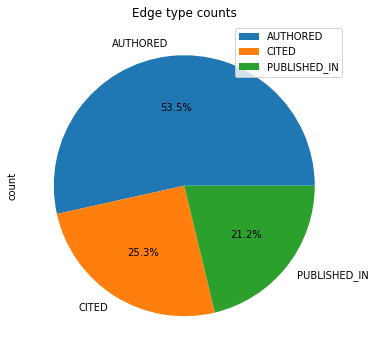

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,0.201790,,0.010327,,1.0,Leonid Naimark
1,0.003210,Jr.,0.062256,Stuart A. Kurtz,0.000673,Jr.,1.0,Il-Woo Lee
2,0.000600,III,0.049367,Jr.,0.000142,Staff,1.0,Qingmao Hu
3,0.000339,II,0.003865,D. R. Stinson,0.000121,III,1.0,S. L. Osborn
4,0.000337,Staff,0.003639,Nira Dyn,0.000083,Stephen L. Nelson,1.0,Chang-Yong Liang
5,0.000181,Ben Shneiderman,0.003478,Gilles Brassard,0.000080,Que Corporation,1.0,Nathan Shnidman
6,0.000178,Philip S. Yu,0.003318,II,0.000073,Microsoft Corporation,1.0,Dimitrios A. Andreou
7,0.000152,Elisa Bertino,0.002859,Joan F. Boyar,0.000069,II,1.0,Nitya Ranganathan
8,0.000148,Thomas J. Cashman,0.002758,Mihir Bellare,0.000062,Gilbert Held,1.0,Serge Dégerine
9,0.000147,Ming Li,0.002491,M. Walker,0.000060,Ruth Maran,1.0,Kenneth Manders


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000708,Introduction to algorithms,0.421335,Robust computational secret sharing and a unif...,0.000084,An overview of the BlueGene/L Supercomputer,1.0,Learning effective and robust knowledge for se...
1,0.000686,"Compilers: principles, techniques, and tools",0.282057,How convincing is your protocol?,0.000057,Introduction to algorithms,1.0,Problems in vlsi layout design
2,0.000561,C4.5: programs for machine learning,0.131491,How to share a secret,0.000047,The nature of statistical learning theory,1.0,Foveation techniques and scheduling issues in ...
3,0.000510,Smalltalk-80: the language and its implementation,0.085246,Statistically-hiding commitment from any one-w...,0.000045,"Compilers: principles, techniques, and tools",1.0,"Automatic, run-time and dynamic adaptation of ..."
4,0.000492,A relational model of data for large shared da...,0.082280,Paillier's cryptosystem revisited,0.000044,C4.5: programs for machine learning,1.0,Enhancing the instruction fetching mechanism u...
5,0.000486,"Time, clocks, and the ordering of events in a ...",0.072436,Security without identification: transaction s...,0.000043,"The art of computer programming, volume 2 (3rd...",1.0,Test data generation and symbolic execution of...
6,0.000479,The nature of statistical learning theory,0.057519,Efficient dispersal of information for securit...,0.000043,Recent AI-Related Dissertations,1.0,Traveling threads: a new multithreaded executi...
7,0.000455,Pattern Classification (2nd Edition),0.056730,Survivable Information Storage Systems,0.000042,"Simulation Modeling and Analysis, 2nd edition",1.0,A framework for specification and implementati...
8,0.000452,"The art of computer programming, volume 1 (3rd...",0.047885,On sharing secrets and Reed-Solomon codes,0.000042,"The art of computer programming, volume 1 (3rd...",1.0,SCATTERING-PARAMETER-BASED MACROMODEL FOR TRAN...
9,0.000436,"The art of computer programming, volume 2 (3rd...",0.033059,The isomorphism conjecture fails relative to a...,0.000039,Adaptation in natural and artificial systems,1.0,Automatic layout synthesis of leaf cells


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006140,Communications of the ACM,0.161455,ACM SIGACT News,0.001390,Computer,1.000000,Proceedings of the 1977 symposium on Artificia...
1,0.004369,Computer,0.139757,Communications of the ACM,0.001386,Communications of the ACM,0.666667,Proceedings of the 1993 ACM/ONR workshop on Pa...
2,0.002982,IEEE Transactions on Computers,0.063963,Journal of Cryptology,0.000894,Discrete Mathematics,0.333333,Proceedings of the sixteenth ACM SIGACT-SIGMOD...
3,0.002927,Discrete Mathematics,0.062577,Proceedings of the 14th ACM conference on Comp...,0.000718,Journal of Computational and Applied Mathematics,0.277778,Proceeding of the 2007 conference on Advances ...
4,0.002826,Theoretical Computer Science,0.058621,Proceedings of the thirty-ninth annual ACM sym...,0.000664,BYTE,0.196970,Proceedings of the Workshop on Frontiers in Co...
5,0.002671,Journal of Computational and Applied Mathematics,0.048471,Computer,0.000660,Theoretical Computer Science,0.181538,2007 Future of Software Engineering
6,0.002508,Microelectronic Engineering,0.015614,Information Processing Letters,0.000637,Fuzzy Sets and Systems,0.153846,Proceeding of the 2008 conference on Applicati...
7,0.002503,Journal of Computational Physics,0.015373,Proceedings of the 8th ACM conference on Compu...,0.000597,Information Processing Letters,0.128205,Decision Analysis
8,0.002414,Fuzzy Sets and Systems,0.014160,SIAM Journal on Computing,0.000588,IEEE Transactions on Computers,0.107143,Proceedings of the Workshop on Parsing German
9,0.002324,Information Processing Letters,0.013654,Journal of the ACM (JACM),0.000572,Journal of Computational Physics,0.106061,Proceedings of the 2nd International Workshop ...


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7795209918876297
Number of communities: 241


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

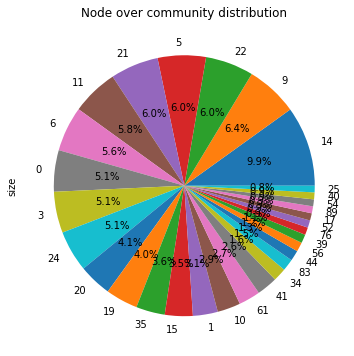

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,0.201790,,0.010327,,1.0,Martin Pichlmair
1,0.004369,Computer,0.048471,Computer,0.001390,Computer,1.0,Carl Strebel
2,0.001630,IEEE Software,0.003039,IEEE Micro,0.000463,IEEE Software,1.0,Mozammel H. A. Khan
3,0.001333,IEEE Micro,0.001834,Cryptography and cryptoanalysis,0.000382,IEEE Micro,1.0,Mosaab Daoud
4,0.001007,IEEE Design Test,0.001834,Operating systems and malware,0.000281,IEEE Design Test,1.0,Andrius Butkus
5,0.000452,IEEE Annals of the History of Computing,0.001834,Data privacy,0.000166,IEEE Annals of the History of Computing,1.0,Mihaela Brut
6,0.000409,ACM SIGCAS Computers and Society,0.001834,ConceptDoppler: a weather tracker for internet...,0.000140,ACM SIGCAS Computers and Society,1.0,The Science of Digital Media
7,0.000340,Journal of Complexity,0.001834,Network security,0.000112,Queue,1.0,Michael Kai Petersen
8,0.000291,Queue,0.001834,Cryptography,0.000094,netWorker,1.0,"Know your enemy: revealing the security tools,..."
9,0.000272,Proceedings of the 22nd International Conferen...,0.001834,Anonymity,0.000092,Journal of Complexity,1.0,Matthew J. Thurley


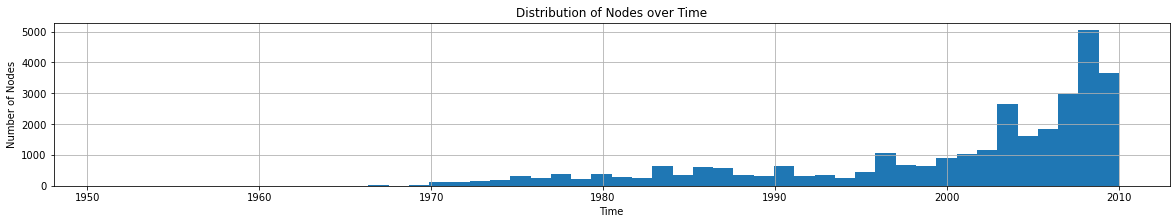

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000559,Analog Integrated Circuits and Signal Processing,0.001543,Big Omicron and big Omega and big Theta,0.000110,Analog Integrated Circuits and Signal Processing,1.0,J. D. Cho
1,0.000472,Proceedings of the conference on European desi...,0.001423,Analog Integrated Circuits and Signal Processing,0.000086,Journal of Electronic Testing: Theory and Appl...,1.0,C. Ouyang
2,0.000457,Journal of Electronic Testing: Theory and Appl...,0.001248,Graph-Based Algorithms for Boolean Function Ma...,0.000080,Proceedings of the conference on European desi...,1.0,Margaret Lie
3,0.000398,Graph-Based Algorithms for Boolean Function Ma...,0.000627,"Integration, the VLSI Journal",0.000071,"Integration, the VLSI Journal",1.0,William A. Dees
4,0.000320,"Integration, the VLSI Journal",0.000511,Journal of Electronic Testing: Theory and Appl...,0.000048,Proceedings of the 1991 IEEE International Con...,1.0,J. E. Bracken
5,0.000213,Proceedings of the 1991 IEEE International Con...,0.000313,Memory Architecture Exploration for Power-Effi...,0.000040,Proceedings of the 45th annual Design Automati...,1.0,Wilfried Rottmann
6,0.000209,Proceedings of the 45th annual Design Automati...,0.000313,Proceedings of the 1991 IEEE International Con...,0.000038,Proceedings of the 2007 Asia and South Pacific...,1.0,Juan Antonio Carballo
7,0.000158,Proceedings of the 2007 IEEE/ACM international...,0.000306,Proceedings of the 20th International Conferen...,0.000037,Proceedings of the 9th international symposium...,1.0,Robi Dutta
8,0.000158,A linear-time heuristic for improving network ...,0.000291,Proceedings of the conference on European desi...,0.000036,Proceedings of the 17th International Conferen...,1.0,Wendy Belluomini
9,0.000157,Proceedings of the 2007 Asia and South Pacific...,0.000259,Proceedings of the 2007 Asia and South Pacific...,0.000034,Proceedings of the 20th International Conferen...,1.0,P. K. Nag


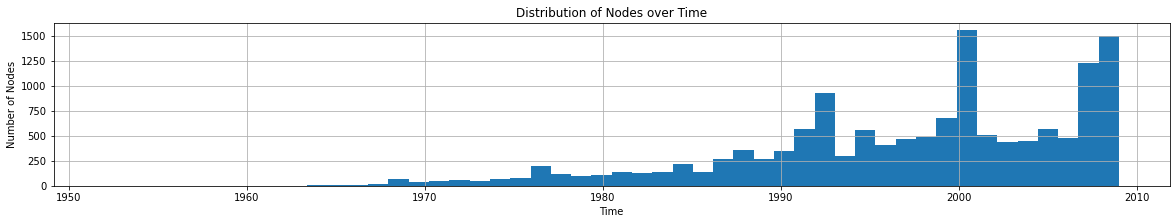

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000200,Cryptologia,0.000383,Cryptologia,0.000072,Cryptologia,1.000000,Robert Popp
1,0.000100,Organised Sound,0.000159,Organised Sound,0.000035,The electronic privacy papers: documents on th...,1.000000,Taina Riikonen
2,0.000086,The electronic privacy papers: documents on th...,0.000117,The electronic privacy papers: documents on th...,0.000034,Organised Sound,1.000000,Yolande Harris
3,0.000047,Building in big brother: the cryptographic pol...,0.000079,Paul Townsend,0.000018,Building in big brother: the cryptographic pol...,0.666667,Towards unified design guidelines for new inte...
4,0.000043,"Cryptology: machines, history and methods",0.000071,Benzocyclobutene (DVS-BCB) polymer as an inter...,0.000018,"Cryptology: machines, history and methods",0.666667,Genres and techniques of soundscape compositio...
5,0.000020,Computers and the Humanities,0.000065,Building in big brother: the cryptographic pol...,0.000007,Anonymous,0.666667,The Meta-Orchestra: research by practice in gr...
6,0.000018,Louis Kruh,0.000054,Advanced telecommunications and encryption (me...,0.000007,Computers and the Humanities,0.666667,Shared sounds in detached movements: flautist ...
7,0.000016,Anonymous,0.000052,Fair Cryptosystems,0.000007,Louis Kruh,0.500000,Soundscape composition as global music: Electr...
8,0.000012,Composing Interactive Music: Techniques and Id...,0.000043,"Cryptology: machines, history and methods",0.000005,David Kahn,0.333333,Experiences with CC2001 at a small college
9,0.000012,David Kahn,0.000040,Oso volume 14 issue 2 cover and back matter,0.000005,CORPORATE AT T,0.333333,Soundscape composition: the convergence of eth...


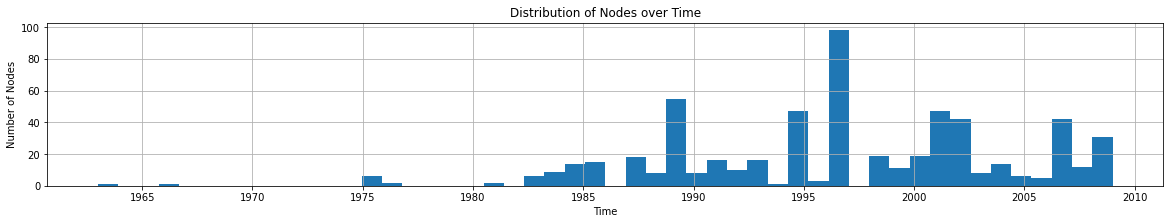

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000613,interactions,0.003499,Toward hypertext publishing,0.000206,interactions,1.0,Jenia Pevzner
1,0.000573,ACM SIGCHI Bulletin,0.002578,The challenge of open systems: current logic p...,0.000143,ACM SIGCHI Bulletin,1.0,Katri Mehto
2,0.000561,Proceedings of the SIGCHI conference on Human ...,0.001262,Animating algorithms with XTANGO,0.000130,International Journal of Man-Machine Studies,1.0,Ann M. Bisantz
3,0.000535,International Journal of Man-Machine Studies,0.000747,Lorrie Faith Cranor,0.000092,Conference companion on Human factors in compu...,1.0,Ann C. Smith
4,0.000453,Conference companion on Human factors in compu...,0.000614,Some computer science issues in ubiquitous com...,0.000078,International Journal of Human-Computer Studies,1.0,Anke Hilgers
5,0.000435,International Journal of Human-Computer Studies,0.000596,Proceedings of the Sixth IEEE International Co...,0.000075,Proceedings of the Sixth IEEE International Co...,1.0,Christine Sweeney
6,0.000313,Proceedings of the 27th international conferen...,0.000581,Designing the user interface (2nd ed.): strate...,0.000075,ACM SIGDOC Asterisk Journal of Computer Docume...,1.0,Anita W. Huang
7,0.000302,Proceedings of the Sixth IEEE International Co...,0.000535,RFID and privacy: what consumers really want a...,0.000058,Proceedings of the SIGCHI conference on Human ...,1.0,Rebeca P. Díaz-Redondo
8,0.000207,ACM SIGDOC Asterisk Journal of Computer Docume...,0.000522,International Journal of Man-Machine Studies,0.000057,Proceedings of the 27th international conferen...,1.0,Rebecca Carr
9,0.000202,Tangible bits: towards seamless interfaces bet...,0.000517,Advances in Mathematical Sketching: Moving Tow...,0.000052,ACM SIGWEB Newsletter,1.0,Rebecca Lunsford


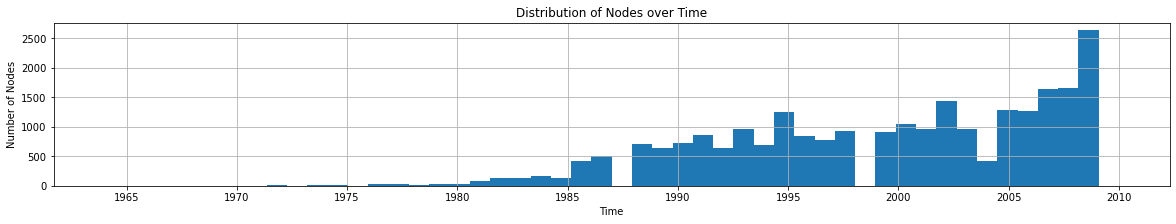

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000060,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.000181,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.000023,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.1,An algorithm using symbolic techniques for the...
1,0.000019,W D Loveland,0.000073,Smith,0.000012,CHEOPS: really using a satellite,0.0,A
2,0.000017,CHEOPS: really using a satellite,0.000068,"CorelDRAW 8 for Dummies, 1st edition",0.000009,W D Loveland,0.0,Big Buck Bunny
3,0.000016,A R Wagner,0.000060,Special programme,0.000008,A R Wagner,0.0,Heavy Duty
4,0.000009,W D Reed,0.000060,Animation theatre,0.000005,Implementation Independent Architectural Compa...,0.0,Clothfighters
5,0.000007,Providing Reliable Distributed Grid Services i...,0.000060,Electronic theatre,0.000004,Search and Destroy,0.0,The Bird
6,0.000007,Implementation Independent Architectural Compa...,0.000056,This Way Up,0.000004,Parallelizing Multidimensional Index Structures,0.0,Out to Play
7,0.000007,Parallelizing Multidimensional Index Structures,0.000045,Lexicographically Optimal Rage Control for Vid...,0.000004,Smith,0.0,Chronos 1.0
8,0.000006,Search and Destroy,0.000028,T,0.000004,Generating Levels of Detail for Large-Scale Po...,0.0,Burley!
9,0.000006,Factors affecting students' use of MEDLINE,0.000025,Parallelizing Multidimensional Index Structures,0.000004,On the Errors That Learning Machines Will Make,0.0,Angkor Ruins: the Bayon Temple and its Faces


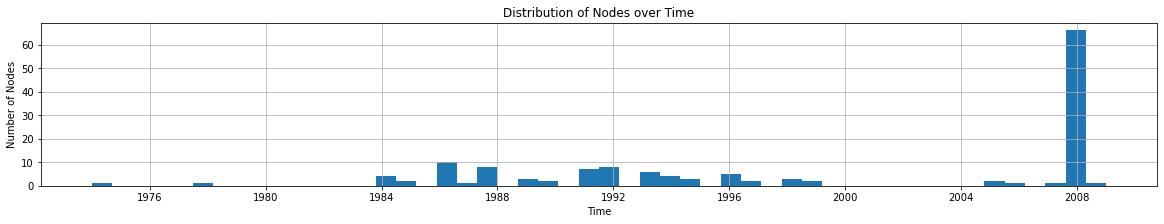

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002927,Discrete Mathematics,0.421335,Robust computational secret sharing and a unif...,0.000894,Discrete Mathematics,1.0,Hiroshi Fujisaki
1,0.002324,Information Processing Letters,0.282057,How convincing is your protocol?,0.000597,Information Processing Letters,1.0,M. W. Newman
2,0.001748,Discrete Applied Mathematics,0.161455,ACM SIGACT News,0.000419,Discrete Applied Mathematics,1.0,Ali A. Kooshesh
3,0.001157,Journal of Combinatorial Theory Series A,0.131491,How to share a secret,0.000329,Journal of Combinatorial Theory Series A,1.0,Christian Gehrmann
4,0.000983,SIAM Journal on Computing,0.085246,Statistically-hiding commitment from any one-w...,0.000220,European Journal of Combinatorics,1.0,Alexandre Linhares
5,0.000751,European Journal of Combinatorics,0.082280,Paillier's cryptosystem revisited,0.000203,Journal of Graph Theory,1.0,Zhenfeng Zhang
6,0.000715,Journal of Combinatorial Theory Series B,0.072436,Security without identification: transaction s...,0.000196,Journal of Combinatorial Theory Series B,1.0,Paul Bamberg
7,0.000664,Journal of Graph Theory,0.063963,Journal of Cryptology,0.000194,SIAM Journal on Computing,1.0,Zhongfei Li
8,0.000645,Journal of Computer and System Sciences,0.062577,Proceedings of the 14th ACM conference on Comp...,0.000182,ACM SIGACT News,1.0,Zsolt Katona
9,0.000575,ACM SIGACT News,0.062256,Stuart A. Kurtz,0.000167,American Mathematical Monthly,1.0,M. Van Eupen


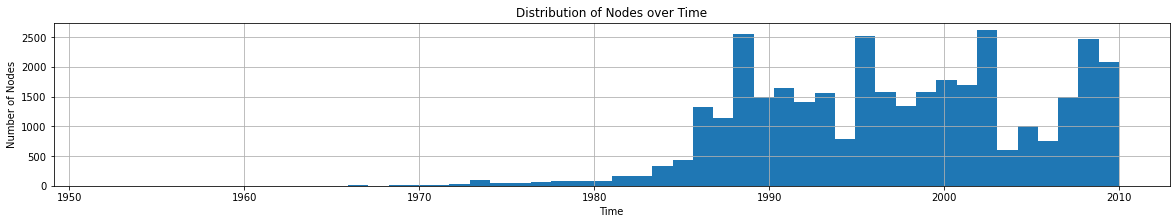

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.7062284109331107
Number of communities: 65800


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

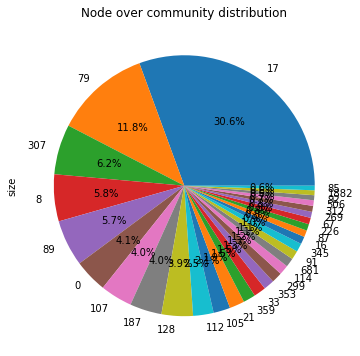

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,0.201790,,0.010327,,1.000000,Mozammel H. A. Khan
1,0.000138,Computers in Entertainment (CIE),0.001847,"Review of ""Complexity and real computation"" by...",0.000045,Computers in Entertainment (CIE),1.000000,D. Chieng
2,0.000124,Proceedings of the The IEEE Conference on Loca...,0.001834,Other contributions,0.000041,Proceedings of the 14th International Conferen...,1.000000,Arjan Peddemors
3,0.000117,Proceedings of the International Conference on...,0.001834,"Review of ""Algebraic and automata-theoretic pr...",0.000039,Proceedings of the 2nd International Symposium...,0.400000,Embracing and Extending Windows 2000
4,0.000107,Proceedings of the 2008 Sixth Annual IEEE Inte...,0.001834,"Review of ""Proofs and refutations: the logic o...",0.000035,Proceedings of the 1996 International Conferen...,0.333333,A fuzzy mathematics based optimal delivery sch...
5,0.000102,Proceedings of the 14th International Conferen...,0.001834,Technical columns,0.000035,Proceedings of the 3rd International Symposium...,0.333333,Goal Algebra for IT Alignment
6,0.000098,Proceedings of the 2nd International Symposium...,0.001834,Cryptosystems,0.000030,Proceedings of the The IEEE Conference on Loca...,0.333333,Defect-Causal Analysis Drives Down Error Rates
7,0.000097,Proceedings of the 3rd International Symposium...,0.001834,Regular features,0.000028,International Conference on Software Engineering,0.333333,Dependency of intentions on i*
8,0.000092,Proceedings of the 1994 ACM/IEEE conference on...,0.001834,Session 7A,0.000026,Proceedings of the 1996 International Symposiu...,0.333333,A. Ting
9,0.000083,Proceedings of the 1996 International Conferen...,0.001834,Education forum,0.000025,Proceedings of the International Conference on...,0.333333,S. Kawade


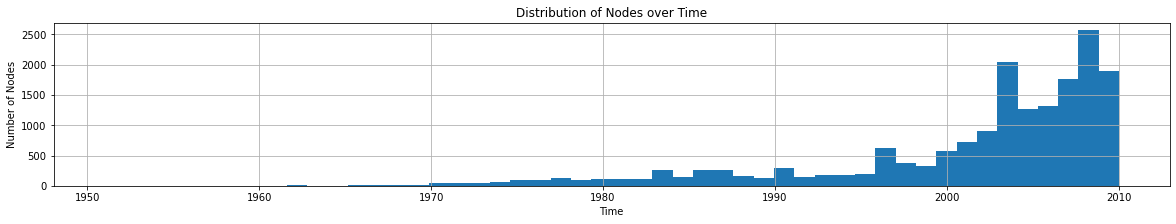

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.591931e-06,Commercial gate array physical design automati...,0.000002,Commercial gate array physical design automati...,1.604139e-06,Commercial gate array physical design automati...,0.0,Commercial gate array physical design automati...
1,8.639772e-07,2nd,0.000000,2nd,3.743898e-07,2nd,NaN,2nd
2,8.639772e-07,Frederick Hinchliffe,0.000000,Frederick Hinchliffe,3.743898e-07,Frederick Hinchliffe,NaN,Frederick Hinchliffe


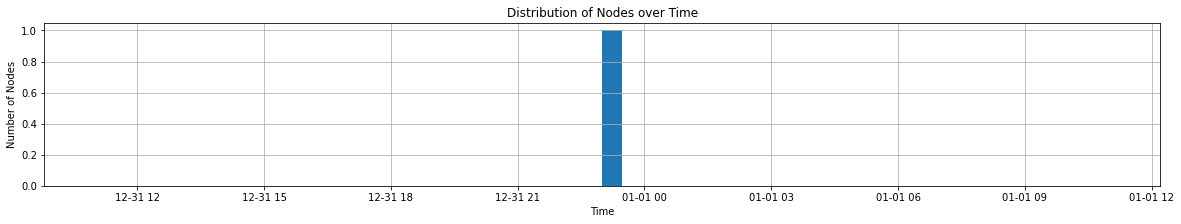

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.591931e-06,Digital Telephony and Communications Privacy I...,0.000002,Digital Telephony and Communications Privacy I...,1.611956e-06,Digital Telephony and Communications Privacy I...,0.0,Digital Telephony and Communications Privacy I...
1,8.639772e-07,2nd Session,0.000000,2nd Session,3.743898e-07,2nd Session,NaN,2nd Session
2,8.639772e-07,CORPORATE 103rd Congress,0.000000,CORPORATE 103rd Congress,3.743898e-07,CORPORATE 103rd Congress,NaN,CORPORATE 103rd Congress


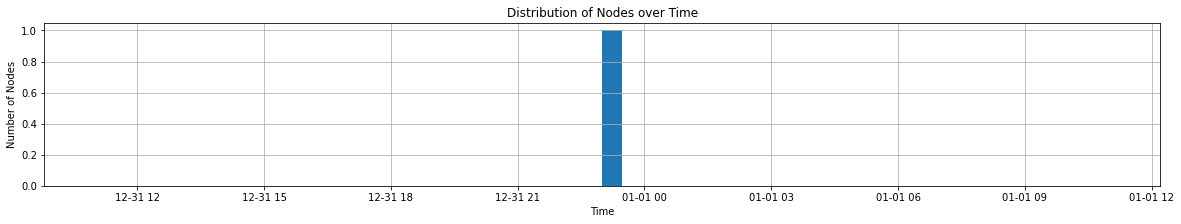

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,4.319886e-06,ConCall: An information service for researcher...,0.000003,ConCall: An information service for researcher...,2.773364e-06,ConCall: An information service for researcher...,0.0,ConCall: An information service for researcher...
1,8.639772e-07,?sa,0.000000,?sa,2.764725e-07,?sa,NaN,?sa
2,8.639772e-07,Mark Tierney,0.000000,Mark Tierney,2.764725e-07,Mark Tierney,NaN,Mark Tierney
3,8.639772e-07,Rudstrom,0.000000,Rudstrom,2.764725e-07,Rudstrom,NaN,Rudstrom


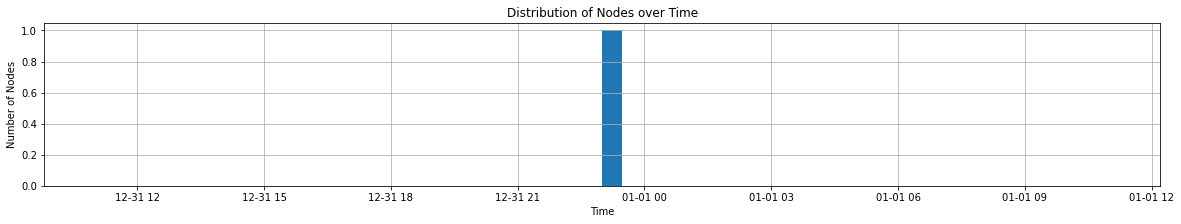

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,5.183863e-06,On the Errors That Learning Machines Will Make,6.047851e-06,A,3.679100e-06,On the Errors That Learning Machines Will Make,0.0,A
1,2.591931e-06,A,5.183872e-06,On the Errors That Learning Machines Will Make,9.863731e-07,W A Biermann,0.0,W A Biermann
2,1.727954e-06,W A Biermann,8.639787e-07,W A Biermann,4.967864e-07,Computer Science for the Many,0.0,On the Errors That Learning Machines Will Make
3,8.639772e-07,B,0.000000e+00,B,4.487020e-07,A,NaN,B
4,8.639772e-07,C K Gilbert,0.000000e+00,C K Gilbert,2.519931e-07,B,NaN,C K Gilbert
5,8.639772e-07,Fahmy,0.000000e+00,Fahmy,2.519931e-07,C K Gilbert,NaN,Fahmy
6,8.639772e-07,Koster,0.000000e+00,Koster,2.519931e-07,Fahmy,NaN,Koster
7,8.639772e-07,Computer Science for the Many,0.000000e+00,Computer Science for the Many,2.519931e-07,Koster,NaN,Computer Science for the Many


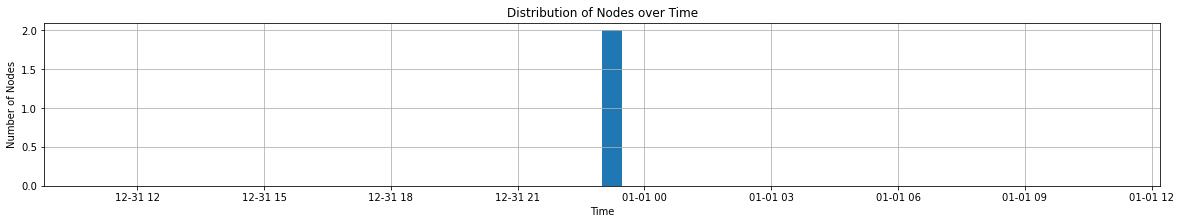

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.591931e-06,On the domatic number of interval graphs,0.000002,On the domatic number of interval graphs,1.598629e-06,On the domatic number of interval graphs,0.0,On the domatic number of interval graphs
1,8.639772e-07,A. Bertossi,0.000000,A. Bertossi,3.743898e-07,A. Bertossi,NaN,A. Bertossi
2,8.639772e-07,Alan,0.000000,Alan,3.743898e-07,Alan,NaN,Alan


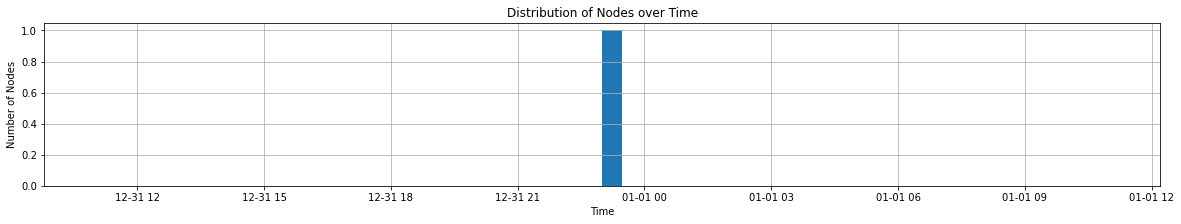

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')